In [2]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from tqdm import tqdm

In [4]:
# Plotting all in a single graph

# MCTS
mypath = 'MCTS_RESULTS/2022_NEW_C'
mcts_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
dates = [file.split("_")[2] for file in mcts_files]

# Baseline
bl_path = 'MCTS_RESULTS/10_2022_BL'
baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
baselines = [b for b in baselines if b.split("_")[3] in dates]

# MCTS NOREALLOC
mypath_NR = 'MCTS_RESULTS/2022_NEW_C_NOREALLOC'
mcts_NR_files = [f for f in listdir(mypath_NR) if isfile(join(mypath_NR, f))]
dates = [file.split("_")[2] for file in mcts_NR_files]

# Baseline NOREALLOC
bl_path_NR = 'MCTS_RESULTS/10_2022_BL_NR'
baselines_NR = [f for f in listdir(bl_path_NR) if isfile(join(bl_path_NR, f))]
baselines_NR = [b for b in baselines_NR if b.split("_")[3] in dates]
print(len(mcts_files), len(baselines), len(mcts_NR_files), len(baselines_NR))

31 31 30 30


In [73]:
def logs_to_df(mypath, onlyfiles, baselines=False, norealloc=False):
    log_file_arr = {}

    for file in tqdm(onlyfiles):
        if baselines:
            date = file.split("_")[3]
        else:
            date = file.split("_")[2]
            
        bus_metrics = []
        stop_metrics = []
        
        start_bus_metrics = False
        start_stop_metrics = False
        
        log_path = f"{mypath}/{file}"
        with open(log_path) as file:
            for line in file:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)[1].strip()
                
                if 'bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status' in line:
                    bus_metrics.append(out_brackets)
                    start_stop_metrics = False
                    start_bus_metrics = True
                    continue
                
                if 'stop_id,total_passenger_ons,total_passenger_offs,total_passenger_walk_away,total_served,service_kms,current_stop,status' in line:
                    stop_metrics.append(out_brackets)
                    start_stop_metrics = True
                    start_bus_metrics = False
                    continue

                if 'Count of all passengers' in line:
                    break
                
                if start_bus_metrics:
                    bus_metrics.append(out_brackets)
                
                if start_stop_metrics:
                    stop_metrics.append(out_brackets)
                    
        # break

        bus_df = pd.DataFrame([sub.split(",") for sub in bus_metrics])
        if bus_df.empty:
            continue
        # display(bus_df.head(1))
        new_header = bus_df.iloc[0] #grab the first row for the header
        bus_df = bus_df[1:] #take the data less the header row
        bus_df.columns = new_header #set the header row as the df header

        bus_df[new_header[:-2]] = bus_df[new_header[:-2]].apply(pd.to_numeric, errors='coerce')
        
        stop_df = pd.DataFrame([sub.split(",") for sub in stop_metrics])
        # display(stop_df.head(1))
        new_header = stop_df.iloc[0] #grab the first row for the header
        stop_df = stop_df[1:] #take the data less the header row
        stop_df.columns = new_header #set the header row as the df header

        stop_df[new_header[1:]] = stop_df[new_header[1:]].apply(pd.to_numeric, errors='coerce')
        stop_df = stop_df[['stop_id', 'total_passenger_ons', 'total_passenger_offs', 'total_passenger_walk_away']]
        # stop_df
        label = 'MCTS'
        if baselines:
            label = 'Greedy'
        nr_label = 'With Reallocation'
        if norealloc:
            nr_label = 'No Reallocation'
        log_file_arr[(date, label, nr_label)] = [bus_df, stop_df]
    return log_file_arr

In [74]:
mcts_logs_arr = logs_to_df(mypath, mcts_files)
mcts_NR_logs_arr = logs_to_df(mypath_NR, mcts_NR_files, norealloc=True)

bl_logs_arr = logs_to_df(bl_path, baselines, baselines=True)
bl_NR_logs_arr = logs_to_df(bl_path_NR, baselines_NR, baselines=True, norealloc=True)

all_files = mcts_logs_arr | mcts_NR_logs_arr | bl_logs_arr | bl_NR_logs_arr

100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


In [85]:
df = []
for (date, baseline, norealloc), data  in all_files.items():
    # print(date, baseline, norealloc)
    tdf = data[0]
    total_served = tdf.total_served.sum()
    overflow_kms = tdf[tdf['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    df.append({"date":date, "Strategy": baseline, "Reallocation": norealloc,
                "total_served":total_served,
                "overflow_kms":overflow_kms})
df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['date'])
df['dow'] = df['date'].dt.day_of_week
df['day'] = df['date'].dt.day_name()

Text(0, 0.5, 'Total Passengers Served')

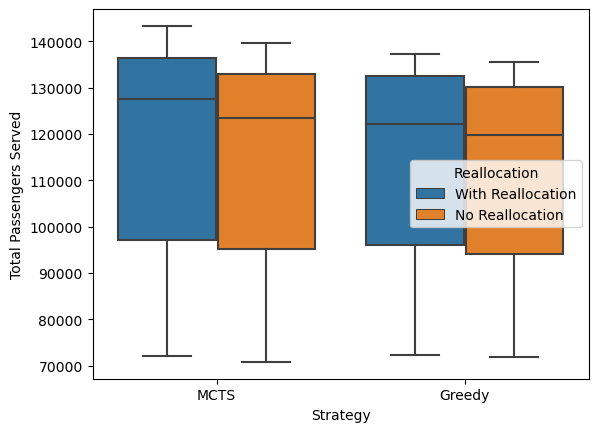

In [87]:
import matplotlib.pyplot as plt

df1 = df[['Strategy', 'Reallocation', 'total_served']].melt(id_vars = [
    'Strategy',
    'Reallocation'
])
import seaborn as sns
sns.boxplot(data = df1, x = 'Strategy', y = 'value', hue = 'Reallocation', showfliers=True)
# plt.legend(title='Reallocation')
# plt.xlabel('Strategy')
plt.ylabel('Total Passengers Served')

Text(0, 0.5, 'Total Non-service KMs')

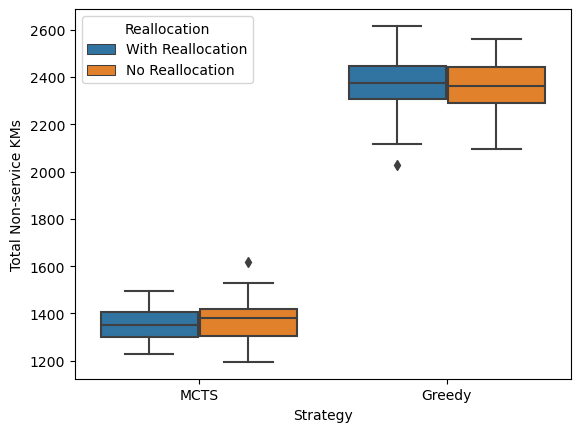

In [88]:
import matplotlib.pyplot as plt
df1 = df[['Strategy', 'Reallocation', 'overflow_kms']].melt(id_vars = [
    'Strategy',
    'Reallocation'
])
import seaborn as sns
sns.boxplot(data = df1, x = 'Strategy', y = 'value', hue = 'Reallocation', showfliers=True)
# plt.legend(title='Reallocation')
# plt.xlabel('Strategy')
plt.ylabel('Total Non-service KMs')

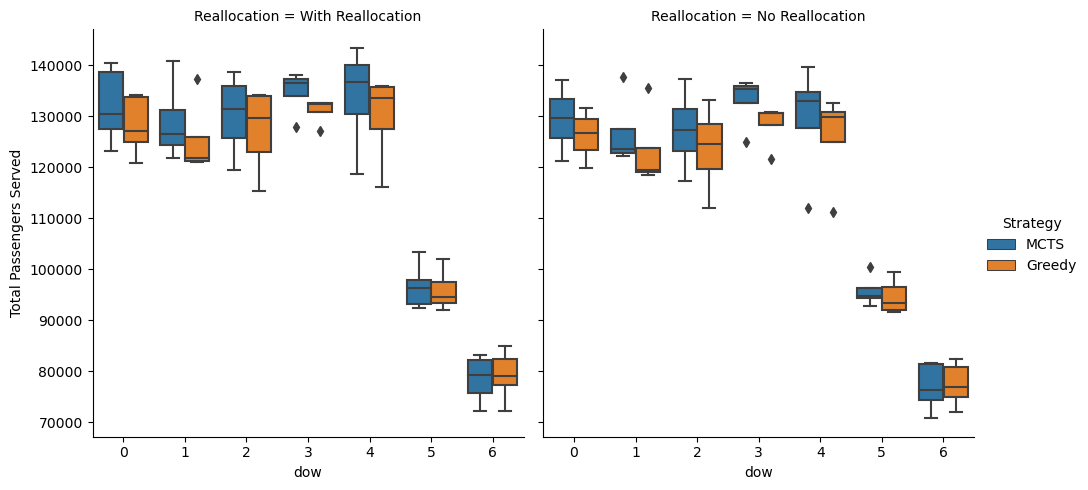

In [92]:
df1 = df[['Strategy', 'Reallocation', 'dow', 'total_served']].melt(id_vars = [
    'Strategy',
    'Reallocation',
    'dow'
])
df1 = df1.rename({'value': 'Total Passengers Served'}, axis=1)
import seaborn as sns
# sns.boxplot(data = df1, x = 'dow', y = 'value', hue = 'baseline', showfliers=True)
sns.catplot(data=df1, x='dow', y='Total Passengers Served', col='Reallocation', hue = 'Strategy', kind='box', col_wrap=2)


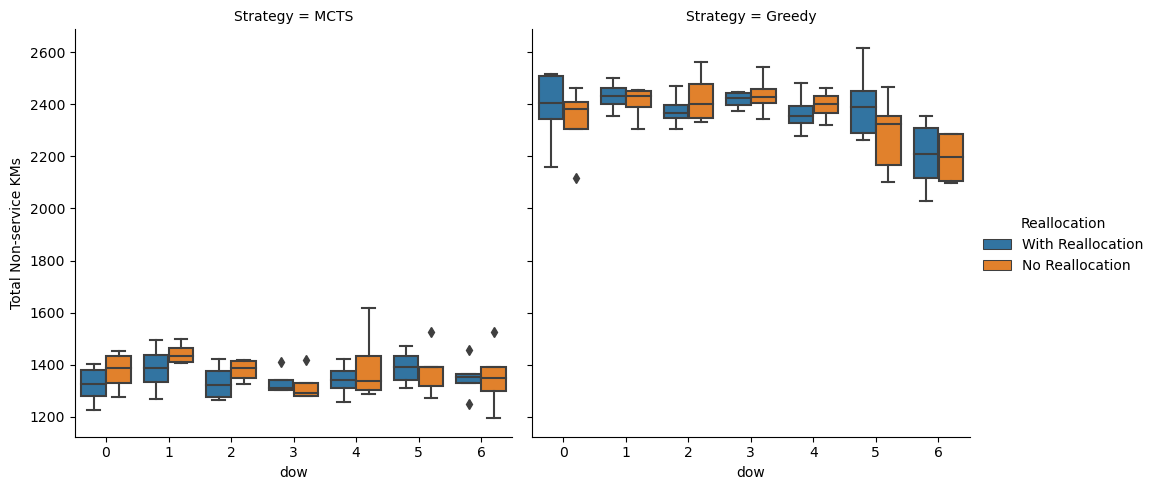

In [95]:
df1 = df[['Strategy', 'Reallocation', 'dow', 'overflow_kms']].melt(id_vars = [
    'Strategy',
    'Reallocation',
    'dow'
])
df1 = df1.rename({'value': 'Total Non-service KMs'}, axis=1)
import seaborn as sns
# sns.catplot(data=df1, x='dow', y='Total Non-service KMs', col='Reallocation', hue = 'Strategy', kind='box', col_wrap=2)
sns.catplot(data=df1, x='dow', y='Total Non-service KMs', col='Strategy', hue = 'Reallocation', kind='box', col_wrap=2)

In [ ]:
# OLD

In [40]:
# mypath = 'MCTS_RESULTS/2022_NEW_C'
# mcts_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# mcts_files = [f for f in mcts_files if 'NOREALLOC' not in f]
# print(mcts_files[0:5])

# bl_path = 'MCTS_RESULTS/2022_NEW_C'
# dates = [file.split("_")[2] for file in mcts_files]
# baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
# baselines = [f for f in baselines if 'NOREALLOC' in f]
# baselines = [b for b in baselines if b.split("_")[2] in dates]

# print(baselines[0:5])

bl_path = '10_2022_BL'
dates = [file.split("_")[2] for file in mcts_files]
baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
baselines = [b for b in baselines if b.split("_")[3] in dates]
print(baselines[0:5])

['no_inject_20221024_200IT_10CAP.log', 'no_inject_20221009_200IT_10CAP.log', 'no_inject_20221004_200IT_10CAP.log', 'no_inject_20221016_200IT_10CAP.log', 'no_inject_20221017_200IT_10CAP.log']
['no_inject_BL_20221008_0IT_10CAP.log', 'no_inject_BL_20221016_0IT_10CAP.log', 'no_inject_BL_20221012_0IT_10CAP.log', 'no_inject_BL_20221013_0IT_10CAP.log', 'no_inject_BL_20221015_0IT_10CAP.log']


In [14]:
bl_path_nr = '10_2022_BL_NR'
baselines_NR = [f for f in listdir(bl_path_nr) if isfile(join(bl_path_nr, f))]
print(baselines_NR[0:5])

bl_path = '10_2022_BL'
baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
print(baselines[0:5])
dates = [file.split("_")[3] for file in baselines]

['no_inject_BL_20221001_0IT_10CAP_NOREALLOC.log', 'no_inject_BL_20221014_0IT_10CAP_NOREALLOC.log', 'no_inject_BL_20221019_0IT_10CAP_NOREALLOC.log', 'no_inject_BL_20221016_0IT_10CAP_NOREALLOC.log', 'no_inject_BL_20221013_0IT_10CAP_NOREALLOC.log']
['no_inject_BL_20221008_0IT_10CAP.log', 'no_inject_BL_20221016_0IT_10CAP.log', 'no_inject_BL_20221012_0IT_10CAP.log', 'no_inject_BL_20221013_0IT_10CAP.log', 'no_inject_BL_20221015_0IT_10CAP.log']


In [10]:
def logs_to_df(mypath, onlyfiles, baselines=False):
    log_file_arr = {}

    for file in tqdm(onlyfiles):
        if baselines:
            date = file.split("_")[3]
        else:
            date = file.split("_")[2]
            
        bus_metrics = []
        stop_metrics = []
        
        start_bus_metrics = False
        start_stop_metrics = False
        
        log_path = f"{mypath}/{file}"
        with open(log_path) as file:
            for line in file:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)[1].strip()
                
                if 'bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status' in line:
                    bus_metrics.append(out_brackets)
                    start_stop_metrics = False
                    start_bus_metrics = True
                    continue
                
                if 'stop_id,total_passenger_ons,total_passenger_offs,total_passenger_walk_away,total_served,service_kms,current_stop,status' in line:
                    stop_metrics.append(out_brackets)
                    start_stop_metrics = True
                    start_bus_metrics = False
                    continue

                if 'Count of all passengers' in line:
                    break
                
                if start_bus_metrics:
                    bus_metrics.append(out_brackets)
                
                if start_stop_metrics:
                    stop_metrics.append(out_brackets)
                    
        # break

        bus_df = pd.DataFrame([sub.split(",") for sub in bus_metrics])
        if bus_df.empty:
            continue
        # display(bus_df.head(1))
        new_header = bus_df.iloc[0] #grab the first row for the header
        bus_df = bus_df[1:] #take the data less the header row
        bus_df.columns = new_header #set the header row as the df header

        bus_df[new_header[:-2]] = bus_df[new_header[:-2]].apply(pd.to_numeric, errors='coerce')
        
        stop_df = pd.DataFrame([sub.split(",") for sub in stop_metrics])
        # display(stop_df.head(1))
        new_header = stop_df.iloc[0] #grab the first row for the header
        stop_df = stop_df[1:] #take the data less the header row
        stop_df.columns = new_header #set the header row as the df header

        stop_df[new_header[1:]] = stop_df[new_header[1:]].apply(pd.to_numeric, errors='coerce')
        stop_df = stop_df[['stop_id', 'total_passenger_ons', 'total_passenger_offs', 'total_passenger_walk_away']]
        # stop_df
        
        log_file_arr[date] = [bus_df, stop_df]
    return log_file_arr

In [11]:
# mcts_logs_arr = logs_to_df(mypath, mcts_files)
bl_logs_arr = logs_to_df(bl_path, baselines, baselines=True)
bl_logs_arr_NR = logs_to_df(bl_path_nr, baselines_NR, baselines=True)
# bl_logs_arr = logs_to_df(bl_path, baselines, baselines=False)

100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


In [12]:
bl_logs_arr_NR

{'20221001': [0   bus_id  dwell_time  agg_delay  service_time  total_served  service_kms  \
  1      132     24328.0      27.81       61702.3        1750.0         0.00   
  2      134     23836.1       0.37       63120.0        1453.0         0.00   
  3      135      3762.5       0.76        9840.0         194.0         0.00   
  4      137         0.0       0.00           0.0           0.0         0.00   
  5     1702     25057.7       5.63       58907.5        1584.0         0.00   
  ..     ...         ...        ...           ...           ...          ...   
  63      43      6592.0     568.66       70393.3        3945.0       463.43   
  64      44      7774.1     768.23       70683.9        3317.0       490.34   
  65      45      5940.3     798.57       69324.7        4017.0       466.91   
  66     711      2249.6     101.38        5122.3         188.0         0.00   
  67     734      3572.7     372.97       28827.1         211.0         0.00   
  
  0  current_stop status 

In [15]:
data = []
for d in dates:
    try:
        bl_bus = bl_logs_arr[d][0]
    except:
        continue
    bl_bus_NR = bl_logs_arr_NR[d][0]
    bl_total_served = bl_bus.total_served.sum()
    mcts_total_served = bl_bus_NR.total_served.sum()
    # print(d, mcts_total_served - bl_total_served)
    
    bl_overflow_kms = bl_bus[bl_bus['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    mcts_overflow_kms = bl_bus_NR[bl_bus_NR['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    # print('\t', d, mcts_overflow_kms, bl_overflow_kms)
    
    percent_diff_served = (mcts_total_served - bl_total_served) / bl_total_served * 100
    percent_diff_mean_deadkms = (bl_overflow_kms - mcts_overflow_kms) / bl_overflow_kms * 100
    
    # data.append({"date":d, "pct_diff_served":percent_diff_served, "pct_diff_deadkms":percent_diff_mean_deadkms})
    data.append({"date":d, 
                 "bl_total_served":bl_total_served,
                 "bl_NR_total_served":mcts_total_served,
                 "bl_overflow_kms":bl_overflow_kms,
                 "bl_NR_overflow_kms":mcts_overflow_kms})
    # bl_stops = bl_logs_arr[d][1]
    # mcts_stops = mcts_logs_arr[d][1]
df = pd.DataFrame(data)

df['date'] = pd.to_datetime(df['date'])
df['dow'] = df['date'].dt.day_of_week
df['day'] = df['date'].dt.day_name()

In [43]:
# data = []
# for d in dates:
#     try:
#         bl_bus = bl_logs_arr[d][0]
#     except:
#         continue
#     mcts_bus = mcts_logs_arr[d][0]
#     bl_total_served = bl_bus.total_served.sum()
#     mcts_total_served = mcts_bus.total_served.sum()
#     # print(d, mcts_total_served - bl_total_served)
    
#     bl_overflow_kms = bl_bus[bl_bus['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
#     mcts_overflow_kms = mcts_bus[mcts_bus['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
#     # print('\t', d, mcts_overflow_kms, bl_overflow_kms)
    
#     percent_diff_served = (mcts_total_served - bl_total_served) / bl_total_served * 100
#     percent_diff_mean_deadkms = (bl_overflow_kms - mcts_overflow_kms) / bl_overflow_kms * 100
    
#     # data.append({"date":d, "pct_diff_served":percent_diff_served, "pct_diff_deadkms":percent_diff_mean_deadkms})
#     data.append({"date":d, 
#                  "bl_total_served":bl_total_served,
#                  "mcts_total_served":mcts_total_served,
#                  "bl_overflow_kms":bl_overflow_kms,
#                  "mcts_overflow_kms":mcts_overflow_kms})
#     # bl_stops = bl_logs_arr[d][1]
#     # mcts_stops = mcts_logs_arr[d][1]
# df = pd.DataFrame(data)

# df['date'] = pd.to_datetime(df['date'])
# df['dow'] = df['date'].dt.day_of_week
# df['day'] = df['date'].dt.day_name()

In [16]:
df['pct_change_served'] = (df.mcts_total_served - df.bl_total_served)/df.bl_total_served
df.mean()

AttributeError: 'DataFrame' object has no attribute 'mcts_total_served'

In [17]:
df

,date,bl_total_served,bl_NR_total_served,bl_overflow_kms,bl_NR_overflow_kms,dow,day
0,2022-10-08,94643.0,91554.0,2450.29,2354.04,5,Saturday
1,2022-10-16,78996.0,76924.0,2353.15,2287.07,6,Sunday
2,2022-10-12,125426.0,122239.0,2303.86,2333.04,2,Wednesday
3,2022-10-13,132082.0,130556.0,2405.28,2433.12,3,Thursday
4,2022-10-15,101932.0,99436.0,2263.80,2166.54,5,Saturday
5,2022-10-27,132584.0,130623.0,2443.20,2343.99,3,Thursday
6,2022-10-09,84886.0,82409.0,2208.43,2284.99,6,Sunday
7,2022-10-30,82432.0,80798.0,2026.95,2096.00,6,Sunday
8,2022-10-29,97406.0,96477.0,2287.98,2100.73,5,Saturday
9,2022-10-02,72218.0,71963.0,2309.89,2197.34,6,Sunday


In [46]:
df = df.drop('pct_change_served', axis=1)

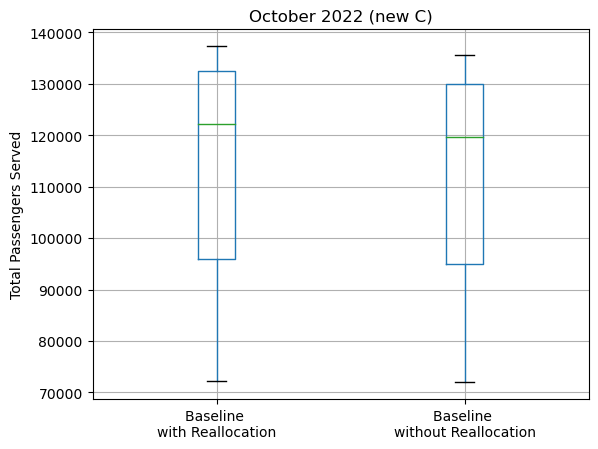

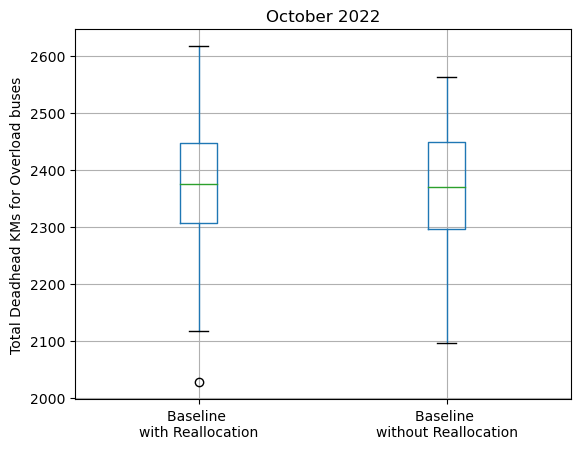

In [20]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# cols_to_norm = ['bl_total_served', 'mcts_total_served']
# df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
ax = df.filter(like='served').boxplot()
# ax.set_xticklabels(['Baseline', 'MCTS'])
ax.set_xticklabels(['Baseline \nwith Reallocation', 'Baseline \nwithout Reallocation'])
ax.set_ylabel('Total Passengers Served')
ax.set_title("October 2022 (new C)")
plt.show()

ax = df.filter(like='kms').boxplot()
# ax.set_xticklabels(['Baseline', 'MCTS'])
ax.set_xticklabels(['Baseline \nwith Reallocation', 'Baseline \nwithout Reallocation'])
ax.set_ylabel('Total Deadhead KMs for Overload buses')
ax.set_title("October 2022")
plt.show()

0
1
2
3
4
5
6


/tmp/ipykernel_98379/1133912578.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'm', 't',  'w',  'th', 'f',  's',  'su'])


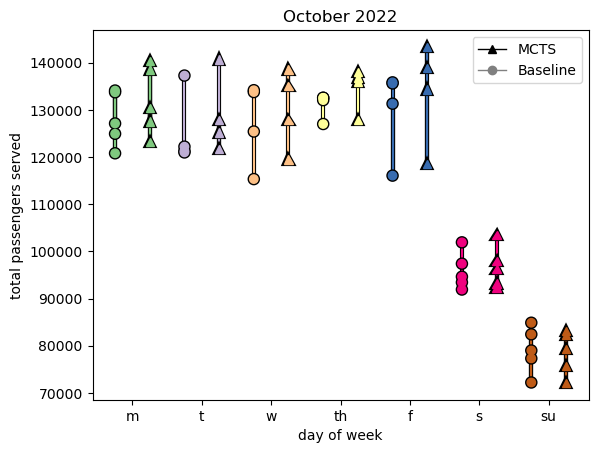

In [48]:
import matplotlib.patheffects as pe

tdf = df.groupby('dow').agg({'day':'first', 'bl_total_served':list, 'mcts_total_served':list}).sort_index()
fig, ax = plt.subplots()
x = 0
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
for k, v in tdf.iterrows():
    print(k)
    i = len(v['bl_total_served'])
    # print([k-0.5]*i)
    # print([k+0.5]*i)
    
    ax.plot([x-0.5]*i, v['bl_total_served'], marker='o', color=colors[k], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
    ax.plot([x+0.5]*i, v['mcts_total_served'], marker='^', color=colors[k], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
    x += 2
    # ax.plot(k, v['bl_total_served'])
    # ax.plot(k, v['mcts_total_served'])
ax.set_xticklabels(['', 'm', 't',  'w',  'th', 'f',  's',  'su'])
ax.set_xlabel('day of week')
ax.set_ylabel('total passengers served')
ax.set_title('October 2022')

from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color='black', lw=1, marker='^'),
                Line2D([0], [0], color='gray', lw=1, marker='o'),
               ]

# ax.legend(custom_lines, ['MCTS \nwith reallocation', 'MCTS \nwithout reallocation'])
ax.legend(custom_lines, ['MCTS', 'Baseline'])

fig.show()

# 2021 Files

In [10]:
bl_path = '10_2021_OLD_C/BL'
baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
# baselines = [b for b in baselines if b.split("_")[3] in dates]
# baselines

dates = [file.split("_")[3] for file in baselines]
print(dates)

mypath = '10_2021_OLD_C'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = [b for b in onlyfiles if b.split("_")[2] in dates]

mcts_logs_arr = logs_to_df(mypath, onlyfiles)
bl_logs_arr = logs_to_df(bl_path, baselines, baselines=True)

['20211011', '20211012', '20211003', '20211018', '20211028', '20211001', '20211010', '20211027', '20211017', '20211013', '20211030', '20211024', '20211021', '20211002', '20211026', '20211023', '20211005', '20211031', '20211004', '20211022']


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


In [11]:
data = []
for d in dates:
    bl_bus = bl_logs_arr[d][0]
    mcts_bus = mcts_logs_arr[d][0]
    bl_total_served = bl_bus.total_served.sum()
    mcts_total_served = mcts_bus.total_served.sum()
    # print(d, mcts_total_served - bl_total_served)
    
    bl_overflow_kms = bl_bus[bl_bus['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    mcts_overflow_kms = mcts_bus[mcts_bus['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    # print('\t', d, mcts_overflow_kms, bl_overflow_kms)
    
    percent_diff_served = (mcts_total_served - bl_total_served) / bl_total_served * 100
    percent_diff_mean_deadkms = (bl_overflow_kms - mcts_overflow_kms) / bl_overflow_kms * 100
    
    # data.append({"date":d, "pct_diff_served":percent_diff_served, "pct_diff_deadkms":percent_diff_mean_deadkms})
    data.append({"date":d, 
                 "bl_total_served":bl_total_served,
                 "mcts_total_served":mcts_total_served,
                 "bl_overflow_kms":bl_overflow_kms,
                 "mcts_overflow_kms":mcts_overflow_kms})
    # bl_stops = bl_logs_arr[d][1]
    # mcts_stops = mcts_logs_arr[d][1]
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df['dow'] = df['date'].dt.day_of_week
df['day'] = df['date'].dt.day_name()

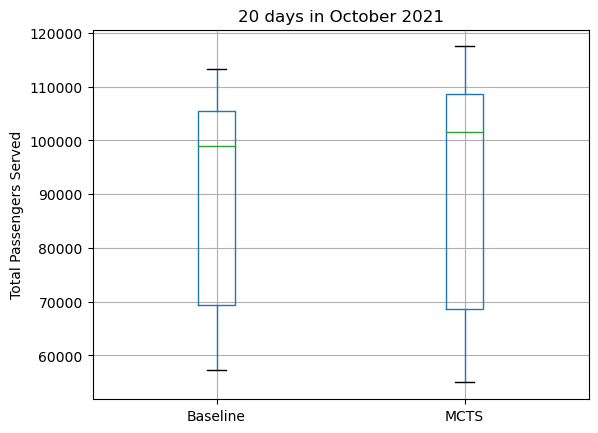

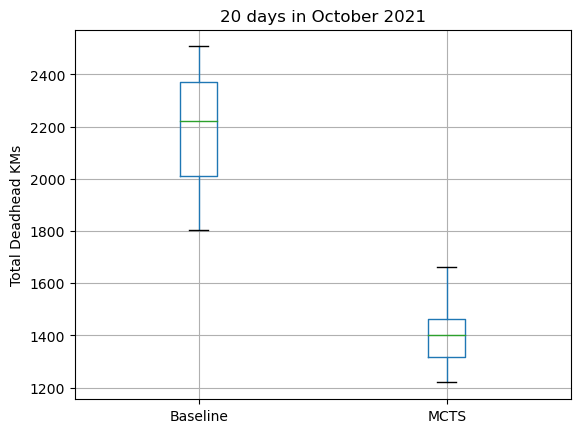

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# cols_to_norm = ['bl_total_served', 'mcts_total_served']
# df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
ax = df.filter(like='served').boxplot()
ax.set_xticklabels(['Baseline', 'MCTS'])
ax.set_ylabel('Total Passengers Served')
ax.set_title("20 days in October 2021")
plt.show()

ax = df.filter(like='kms').boxplot()
ax.set_xticklabels(['Baseline', 'MCTS'])
ax.set_ylabel('Total Deadhead KMs')
ax.set_title("20 days in October 2021")
plt.show()

0
1
2
3
4
5
6


/tmp/ipykernel_21159/2916764673.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'm', 't',  'w',  'th', 'f',  's',  'su'])


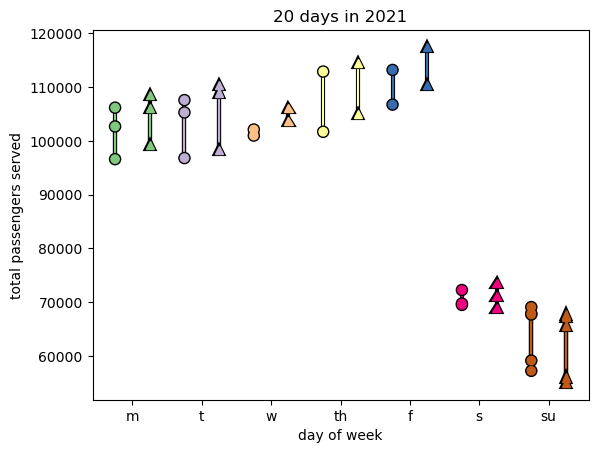

In [13]:
import matplotlib.patheffects as pe

tdf = df.groupby('dow').agg({'day':'first', 'bl_total_served':list, 'mcts_total_served':list}).sort_index()
fig, ax = plt.subplots()
x = 0
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
for k, v in tdf.iterrows():
    print(k)
    i = len(v['bl_total_served'])
    # print([k-0.5]*i)
    # print([k+0.5]*i)
    
    ax.plot([x-0.5]*i, v['bl_total_served'], marker='o', color=colors[k], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
    ax.plot([x+0.5]*i, v['mcts_total_served'], marker='^', color=colors[k], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
    x += 2
    # ax.plot(k, v['bl_total_served'])
    # ax.plot(k, v['mcts_total_served'])
ax.set_xticklabels(['', 'm', 't',  'w',  'th', 'f',  's',  'su'])
ax.set_xlabel('day of week')
ax.set_ylabel('total passengers served')
ax.set_title('20 days in 2021')
fig.show()